In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import shapely
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.geometry import MultiPoint

In [71]:
from math import ceil, floor, sin, cos, sqrt
from enum import Enum
class Dataset(Enum):
    AND_GRID = 0 #Basic AND function
    BASIC_GRID = 1 #Basic grid 4x4 with 8xO and 8xX
    BOOL_FUNC = 2 #Boolean function of 5 variables
    POLYGON = 3 #Polygon shape dividing 2D grid to 2 classes
    MULTI_CLASS = 4 #Function dividing 2D grid to 8 classes

In [107]:
polygon_coords = [(0.5,0.5),(1,2.5),(2.5,4),(3,3),(2.5,2.5),(3.5,1),(2.5,0),(2,2),(1.5,1),(0.5,0.5)]
polygon = Polygon(polygon_coords)

def get_top_left_corner(point):
    #Returns top left coords of a square the point belongs to
    top_left = []
    top_left.append(floor(point[0]))
    top_left.append(ceil(point[1]))
    return top_left

def get_multi_class_label(point):
    top_left_corner = get_top_left_corner(point)
    x = top_left_corner[0]
    y = top_left_corner[1]
    label = x
    if y == 1 or y == 3:
        label = x + 4
    return label

def get_true_label(point, dataset, center_dataset=True):
    if center_dataset:
        point[0] += 2
        point[1] += 2
        
    label = 0
    if dataset == Dataset.POLYGON:
        if Point(point).within(polygon):
            label = 1
    elif dataset == Dataset.AND_GRID:
        if point[0] >= 2 and point[1] >= 2:
            label = 1
    
    elif dataset == Dataset.BASIC_GRID:
        l = get_multi_class_label(point)
        if l in [0,1,3,5]:
            label = 1

    else:
        print("Not implemented.")
        
    if label == 0:
        label = -1
        
    return label*1.0

def step_func(x):
    if x <= 0:
        return -1.0
    else:
        return 1.0

In [73]:
def generate_grid_points(count_per_side):
    size_x = 4
    size_y = 4
    start_x = -2
    start_y = -2
    xs = np.linspace(start_x,start_x+size_x, count_per_side)
    ys = np.linspace(start_y,start_y+size_y, count_per_side)
    xv, yv = np.meshgrid(xs, ys)
    points = np.array(np.zeros(shape=(3,xv.flatten().shape[0]), dtype=float))
    points[0] = xv.flatten()
    points[1] = yv.flatten()
    return points

def get_grid_points_with_labels(count_per_side, label_func):
    points = generate_grid_points(count_per_side)
    labels = []
    for i in range(len(points[0])):
        point = np.array([points[0][i], points[1][i]])
        label = label_func(point)
        points[2,i] = label
        labels.append(label)

    return points

def get_dataset_grid_points_with_labels(count_per_side, dataset):
    points = generate_grid_points(count_per_side)
    labels = []
    for i in range(len(points[0])):
        point = [points[0][i], points[1][i]]
        label = get_true_label(point, dataset)
        points[2,i] = label
        labels.append(label)

    #points[2] = np.array(labels)
    return points

def plot_dataset(dataset):
    if dataset in [Dataset.POLYGON, Dataset.MULTI_CLASS, Dataset.BASIC_GRID, Dataset.AND_GRID]:
        points = get_dataset_grid_points_with_labels(100, dataset)
        plt.scatter(points[0],points[1],c=points[2])
        plt.show()
    else:
        print("Not implemented yet.")

In [114]:
class Perceptron:
    def __init__(self, learn_rate):
        self.input_dims = 2
        #self.w = (-1)*np.random.rand(self.input_dims,)
        self.w = np.zeros((self.input_dims,), dtype=float)
        self.b = 0
        self.learn_rate = learn_rate
    
    def out(self, x):
        x = x.flatten()
        return step_func(np.dot(x,self.w) + self.b)
    
    def update_w(self, xs, ys, batch_size):
        assert len(xs) == len(ys)
        print("Before training: ")
        self.plot()
        print("Started training with",len(xs),"examples and batch size =",batch_size)
        
        dw = np.zeros((self.input_dims,), dtype=float)
        i = 0
        
        for x,y in zip(xs,ys):
            if i == batch_size:
                i = 0
                self.w += dw
                dw = np.zeros((self.input_dims,), dtype=float)
            
            dw += self.learn_rate*(y - self.out(x))*x
            i+=1
        
        self.w += dw
        print("After training: ")
        self.plot()
    
    def plot(self):
        print("W =", self.w)
        print("b =", self.b)
        points = get_grid_points_with_labels(100, self.out)
        plt.scatter(points[0],points[1],c=points[2])
        plt.show()

In [119]:
def get_train_data(dataset, number_of_points, plot_data=True):
    print("Getting training data for dataset", dataset,":")
    if plot_data:
        plot_dataset(dataset)
    points = get_dataset_grid_points_with_labels(floor(sqrt(number_of_points*1.0)), dataset)
    points = points.T
    np.random.seed(0)
    np.random.shuffle(points)
    xs = points[:,0:2]
    ys = points[:,2]
    return xs, ys

Getting training data for dataset Dataset.AND_GRID :


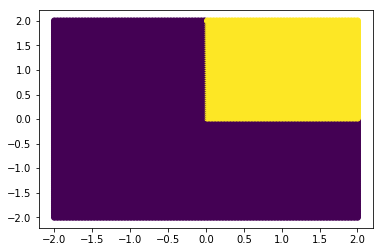

Before training: 
W = [ 0.  0.]
b = 0


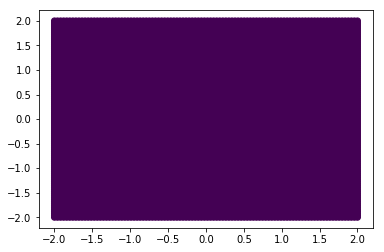

Started training with 10000 examples and batch size = 100
After training: 
W = [ 0.72727273  4.50909091]
b = 0


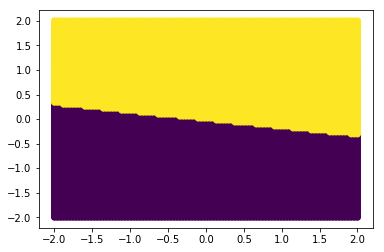

In [126]:
xs, ys = get_train_data(Dataset.AND_GRID, 10000)
p = Perceptron(learn_rate=0.1)
p.update_w(xs=xs, ys=ys, batch_size=100)

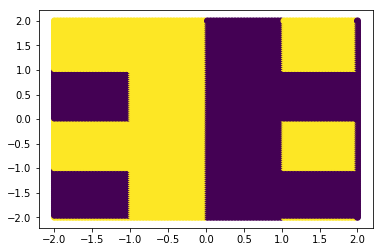

In [117]:
plot_dataset(Dataset.BASIC_GRID)

Getting training data for dataset Dataset.BASIC_GRID :
Before training: 
W = [ 0.  0.]
b = 0


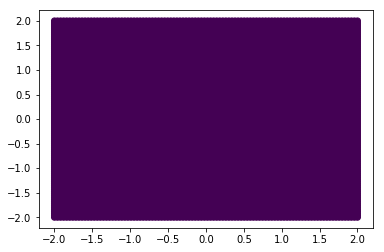

Started training with 10000 examples and batch size = 100
After training: 
W = [-4.81212121  1.82222222]
b = 0


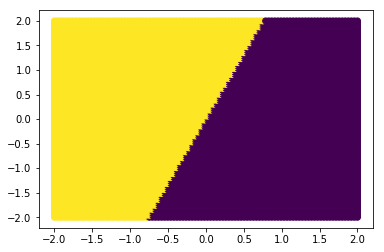

In [125]:
xs, ys = get_train_data(Dataset.BASIC_GRID, 10000, plot_data=False)
p = Perceptron(learn_rate=0.1)
p.update_w(xs=xs, ys=ys, batch_size=100)